<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

: 

: 

In [1]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

c:\Users\a\Documents\UBA\procesamiento_lenguaje_natural\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-22 18:49:39 INFO: Downloading default packages for language: es (Spanish)...
2023-07-22 18:49:41 INFO: File exists: C:\Users\a\stanza_resources\es\default.zip.
2023-07-22 18:49:48 INFO: Finished downloading models and saved to C:\Users\a\stanza_resources.
2023-07-22 18:49:48 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-07-22 18:49:48 INFO: Use device: cpu
2023-07-22 18:49:48 INFO: Loading: tokenize
2023-07-22 18:49:48 INFO: Loading: mwt
2023-07-22 18:49:48 INFO: Loading: pos
2023-07-22 18:49:48 

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [3]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])

    doc = nlp(text)
    # quitando stopwords
    text = [t.text for t in doc if not t.is_stop]

    text = ' '.join(text)
    return text

In [4]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas cosas peces murcielagos'

In [5]:
# Ejemplo de como funciona
text = "hola personas Ideas! como estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas cosas peces murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[cosas, 'cosa']
[peces, 'pez']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [13]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Saludos", "Buenas", "Buenas tardes", "Buenos dias", "Buenas noches",
                           "Hey","Que onda", "Como andas?"
                           ],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?","¿Vos sos?", "¿Como te llamas?"],
              "responses": ["Mi nombre es TiendaPro", "Yo soy TiendaPro"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto",
                          "número de teléfono", "número de whatsapp", "whatsapp",
                          "pasame el número","dame tu número", "¿como te contacto?"
                          ],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?","¿Hacen envios?", "¿Cómo me llega el paquete?"
                           ],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
              "responses": ["Los productos publicados están en stock"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias", "Te lo agradezco"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Nos vemos", "Adios"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [14]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [15]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['adios', 'agradecer', 'andar', 'chau', 'contacto', 'credito', 'cuota', 'damar', 'disponible', 'envio', 'gracias', 'hey', 'holar', 'llama', 'llegar', 'medio', 'noche', 'nombre', 'numerar', 'numero', 'onda', 'pago', 'paquete', 'pasamar', 'pasar', 'poder', 'precio', 'realizar', 'salir', 'saludo', 'ser', 'stock', 'tarde', 'tarjeta', 'telefono', 'tener', 'valer', 'ver', 'whatsapp', 'yo']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'despedida', 'envios', 'nombre', 'pagos', 'precios', 'stock']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Saludos', 'Buenas', 'Buenas tardes', 'Buenos dias', 'Buenas noches', 'Hey', 'Que onda', 'Como andas?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Vos sos?', '¿Como te llamas?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', 'pasame el número', 'dame tu número', '¿como te contacto?', '¿Realizan envios?', '¿Hacen envios?', '¿Cómo me llega el paquete?', 'precio', 'Me podrás pasar los precios', '¿Cuánto 

In [16]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 40


In [17]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [18]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [19]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (40,) output: 9


In [37]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               5248      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 9)                 585       
                                                                 
Total params: 14089 (55.04 KB)
Trainable params: 14089 (55.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [38]:
hist = model.fit(x=train_X, y=train_y, 
                 epochs=300,
                 batch_size = 16,
                 callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'loss',patience=20)]
                 )

Epoch 1/300
3/3 [==============================] - 1s 3ms/step - loss: 2.2216 - accuracy: 0.1136
Epoch 2/300
3/3 [==============================] - 0s 6ms/step - loss: 2.2282 - accuracy: 0.1364
Epoch 3/300
3/3 [==============================] - 0s 5ms/step - loss: 2.1884 - accuracy: 0.2045
Epoch 4/300
3/3 [==============================] - 0s 5ms/step - loss: 2.1700 - accuracy: 0.2273
Epoch 5/300
3/3 [==============================] - 0s 3ms/step - loss: 2.1710 - accuracy: 0.1591
Epoch 6/300
3/3 [==============================] - 0s 3ms/step - loss: 2.1450 - accuracy: 0.1818
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 2.1045 - accuracy: 0.3182
Epoch 8/300
3/3 [==============================] - 0s 5ms/step - loss: 2.1384 - accuracy: 0.3636
Epoch 9/300
3/3 [==============================] - 0s 5ms/step - loss: 2.1714 - accuracy: 0.2045
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 2.0780 - accuracy: 0.4091
Epoch 11/300
3/3 [===========

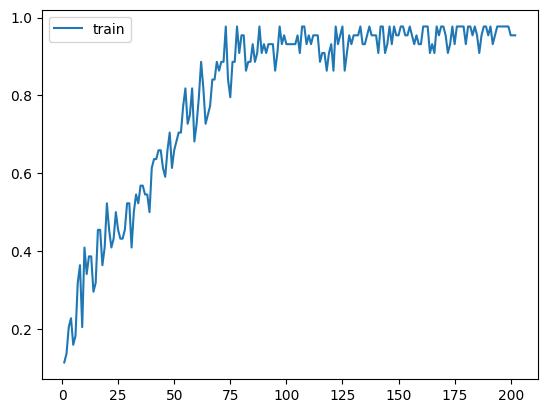

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [2]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

NameError: name 'words' is not defined

### 6 - Testing y validación

In [40]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1

    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)
    print(words_recognized)
    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: hola
1
1/1 [==============================] - 0s 157ms/step
BOT: Hola!
Q: como estas?
0
BOT: Perdón, no comprendo la pregunta.
Q: dame algo
1
1/1 [==============================] - 0s 30ms/step
BOT: Contactos al whatsapp <numero>
Q: quien sos?
1
1/1 [==============================] - 0s 30ms/step
BOT: Mi nombre es TiendaPro
Q: y tenes numero de contacto?
3
1/1 [==============================] - 0s 41ms/step
BOT: Podes contactarnos al siguiente <numero>
Q: Pueden hacer envios?
1
1/1 [==============================] - 0s 40ms/step
BOT: Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>
Q: cuanto vale?
1
1/1 [==============================] - 0s 37ms/step
BOT: En el siguiente link podrás encontrar los precios de todos nuestros productos en stock
Q: y los medios de pago?
2
1/1 [==============================] - 0s 35ms/step
BOT: En el siguiente link podrás encontrar los beneficios y formas de pago vigentes
Q: y tenes stock?
2
1/1 [=====================

: 

: 

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

# Cambios realizados

- se agregaron frases
- filtrado de stopwords
- numero de epocas, batch_size y callbacks implementados

# Conclusiones

Se filtaron los stop words sin embargo esto afecta al modelo, si bien reduce la cantidad de parametros, en español las frases de saludo :
-   como estas?
-   que tal?

contienen palabras consideradas como stopwords asi que el modelo no logra reconocer y contestar correctamente.

Por otro lado se probo con frases las cuales no estan presentes explicitamente como pueden hacer envios? sin embargo contiene una similitud con las frases de entrenamiento,